In [1]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from IPython.display import clear_output

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

2024-03-28 17:00:38.529554: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 17:00:38.529647: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 17:00:38.686402: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
class PairedImageDataset(Dataset):
    def __init__(self, rootA, rootB, transform=None):
        """
        Args:
            rootA (string): Directory with all the images in trainA.
            rootB (string): Directory with all the images in trainB.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.rootA = rootA
        self.rootB = rootB
        self.transform = transform

        # Assuming filenames in both folders are the same and in order
        self.filenames = sorted(os.listdir(rootA))

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_nameA = os.path.join(self.rootA, self.filenames[idx])
        imageA = Image.open(img_nameA).convert('RGB')
        
        img_nameB = os.path.join(self.rootB, self.filenames[idx])
        imageB = Image.open(img_nameB).convert('RGB')

        if self.transform:
            imageA = self.transform(imageA)
            imageB = self.transform(imageB)

        return imageA, imageB

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_dims, s_img, hdim, kernel_size = (4,4), stride =2, padding = 1):
        super(Encoder, self).__init__()

        self.layers = nn.ModuleList()

        # layer 1
        self.layers.append(
            nn.Conv2d(
                in_channels=hdim[0],
                out_channels=hdim[1],
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            )
        )

        self.layers.append(nn.LeakyReLU(0.2))

        # the rest of the layers
        for in_out in range(1, (len(hdim) - 1)):
            self.layers.append(
                nn.Conv2d(
                    in_channels=hdim[in_out],
                    out_channels=hdim[(in_out + 1)],
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding,
                )
            )

            self.layers.append(nn.BatchNorm2d(hdim[in_out + 1]))

            self.layers.append(nn.LeakyReLU(0.2))


    def forward(self, x):

        SkipConnections = []

        for layer in self.layers:
            # print(layer)
            x = layer.forward(x)
            SkipConnections.append(x)

        return x, SkipConnections

In [4]:
#decoder
class Decoder(nn.Module):
    def __init__(self, latent_dims, s_img, hdim_in, hdim_out, kernel_size = (4,4), stride =2, padding= 1):
        super(Decoder, self).__init__()

        self.layers = nn.ModuleList()

        # layers 1 to 3 with dropout
        for in_out in range(0, 3):
            self.layers.append(
                nn.ConvTranspose2d(
                    in_channels=hdim_in[in_out],
                    out_channels=hdim_out[(in_out + 1)],
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding,
                )
            )

            self.layers.append(nn.BatchNorm2d(hdim_out[in_out + 1]))
            self.layers.append(nn.Dropout2d(0.5))
            self.layers.append(nn.ReLU())

        # the rest of the layers 
        for in_out in range(3, (len(hdim_in) - 1)):
            self.layers.append(
                nn.ConvTranspose2d(
                    in_channels=hdim_in[in_out],
                    out_channels=hdim_out[(in_out + 1)],
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding,
                )
            )

            self.layers.append(nn.BatchNorm2d(hdim_out[in_out + 1]))
            self.layers.append(nn.Identity())
#             self.layers.append(nn.Dropout2d(0.5))
            self.layers.append(nn.ReLU())
        
        
            
    def forward(self, z, SkipConnections):
        
        EncoderIndex = 3/4
        SkipConnections.reverse()

        for i, layer in enumerate(self.layers):
            if i % 4 == 0 and i != 0:
                j = int(EncoderIndex * i)
                z = layer.forward(torch.add(z, SkipConnections[j]))
#                 z = layer.forward(torch.cat((z,SkipConnections[j]), 1)) 
                    
            else:
                z = layer.forward(z)
                
        z = torch.tanh(z)
#         z = z * 255
        return z

In [5]:
#Generator
class Generator(nn.Module):
    def __init__(self,
                latent_dims,
                s_img,
                hdim_e,
                hdim_d_input,
                hdim_d_output,
                kernel_size, 
                padding):
        super(Generator, self).__init__()

        self.encoder = Encoder(
            latent_dims=latent_dims,
            s_img=s_img,hdim=hdim_e,
            kernel_size= kernel_size,
            padding= padding)
        self.decoder = Decoder(
            latent_dims=latent_dims,
            s_img=s_img, 
            hdim_in=hdim_d_input, 
            hdim_out=hdim_d_output,
            kernel_size=kernel_size, 
            padding=padding)

    def forward(self, x):

        z, skipConnections = self.encoder(x)
        # print(f"the shape of encoder is {z.shape}")
        y = self.decoder(z, skipConnections)

        return y

In [6]:

def generator_test():
    #test auo-encoder
    n_samples, in_channels, s_img, latent_dims, padding = 64, 3, 256, 512,1
    hdim_e = [3, 64, 128, 256, 512, 512, 512, 512, 512] #choose hidden dimension encoder
#     hdim_d_input = [512, 1024, 1024, 1024, 1024, 512, 256, 128, 3] #choose hidden dimension decoder
    hdim_d_output = [512, 512, 512, 512, 512, 256, 128, 64, 3]
    hdim_d_input = hdim_d_output
    kernel_size = (4,4)

    #generate random sample
    x = torch.randn((n_samples, in_channels, s_img, s_img))
    print(x.shape)

    #initialize model
    model = Generator(latent_dims=latent_dims,
                        s_img=s_img,
                        hdim_e=hdim_e, 
                        hdim_d_input=hdim_d_input,
                        hdim_d_output=hdim_d_output, 
                        padding=padding,
                        kernel_size=kernel_size)
    x_hat = model.forward(x)

    #compare input and output shape
    print('Output check:', x_hat.shape == x.shape)
    print('shape xhat', x_hat.shape)

    #summary of auto-encoder
    summary(model, (3 ,in_channels, s_img, s_img), device='cpu', depth=5,)  # (in_channels, height, width)


generator_test()

torch.Size([64, 3, 256, 256])
Output check: True
shape xhat torch.Size([64, 3, 256, 256])


In [7]:
class Discriminator(nn.Module):
    
    def __init__(self, latent_dims, s_img, hdim, kernel_size=(4, 4), stride=2):
        
        super(Discriminator, self).__init__()

        ########################################################################
        #    Create the necessary layers                                 #
        ########################################################################

        self.layers = nn.ModuleList()
        
        # Input layer dim -- down1
        self.layers.append(nn.Conv2d(in_channels=6, out_channels=64, kernel_size=kernel_size, stride=2, padding=1))

        # Hidden to hidden convolution -- down2 and down 3
        for i in range(0, 2):
            self.layers.append(nn.Conv2d(in_channels=hdim[i],
                                             out_channels=hdim[i + 1],
                                             kernel_size=kernel_size, stride = stride, padding=1))

        # Pad with zeroes
        self.layers.append(nn.ZeroPad2d(padding=(1,1,1,1)))

        # Conv2D
        self.layers.append(nn.Conv2d(in_channels=hdim[3],
                                             out_channels=hdim[4],
                                             kernel_size=kernel_size, stride = 1))

        # Batchnorm
        self.layers.append(nn.BatchNorm2d(hdim[4]))

        # Zeropad2
        self.layers.append(nn.ZeroPad2d(padding=(1,1,1,1)))

        #Conv2D 2
        self.layers.append(nn.Conv2d(in_channels=hdim[5],
                                             out_channels=hdim[6],
                                             kernel_size=kernel_size, stride = 1))

        self.Leakyrelu = nn.LeakyReLU(0.2)
        
    def forward(self, x):

        for n_layer, layer in enumerate(self.layers):
            ## The fourth layer first has a batchnorm and then a Leakyrelu
            if n_layer != 4:
                x = self.Leakyrelu(layer(x))
            else:
                x = layer(x)
        return x
        

In [11]:
def train_gan(train_loader, net_gen, net_dis, optimizer_gen, optimizer_dis, criterion_l1, criterion_bce, pin_memory , device = 'cpu'):
    """
    Trains network for one epoch in batches.

    Args:
        train_loader: Data loader for training set.
        net: Neural network model.
        optimizer: Optimizer (e.g. SGD).
        criterion: Loss function (e.g. cross-entropy loss).
        device: whether the network runs on cpu or gpu
    """
    
#     labels = torch.zeros(30, 30)

    avg_loss_gen = 0
    avg_loss_dis = 0


    # iterate through batches
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        under_water_img, ground_truth = data
        
        # convert the inputs to run on GPU if set
        if device != 'cpu':
            under_water_img, ground_truth = under_water_img.cuda(non_blocking=pin_memory), ground_truth.cuda(non_blocking=pin_memory)
            

        # zero the parameter gradients
        optimizer_gen.zero_grad()
        optimizer_dis.zero_grad()
        
        # forward + backward + optimize
        outputs_gen = net_gen.forward(under_water_img)
        
        inputs_dis_fake = torch.cat((under_water_img, outputs_gen), dim=1) #todo
        inputs_dis_true = torch.cat((under_water_img, ground_truth), dim=1)
        
        outputs_dis_fake = net_dis.forward(inputs_dis_fake) 
        outputs_dis_true = net_dis.forward(inputs_dis_true)
        
        ones = torch.ones(outputs_dis_fake.shape, requires_grad=False).to(device)
        zeros = torch.zeros(outputs_dis_fake.shape, requires_grad=False).to(device)
        
#         print(criterion_l1(outputs_gen,ground_truth))
#         print(criterion_bce(ones,outputs_dis_fake))
        # loss generatortorch.sigmoid(outputs)
        loss_gen_bce = criterion_bce(torch.sigmoid(outputs_dis_fake), ones)# Dit is niet kapot!!!!!!!
        loss_gen_l1 = torch.mul(criterion_l1(outputs_gen,ground_truth),100)
        loss_gen_tot = torch.add(loss_gen_bce, loss_gen_l1)
        loss_gen_tot.backward()
        optimizer_gen.step()
        
#         torch.cuda.synchronize(device=device)
        
#         #loss discriminator
        loss_dis_bce_fake = criterion_bce(torch.sigmoid(outputs_dis_fake.detach()), zeros)
        loss_dis_bce_true = criterion_bce(torch.sigmoid(outputs_dis_true), ones.detach())
        loss_dis_tot = torch.add(loss_dis_bce_fake, loss_dis_bce_true)
        loss_dis_tot.backward()
        optimizer_dis.step()
        

        # keep track of loss and accuracy
        avg_loss_gen += loss_gen_tot
        avg_loss_dis += loss_dis_tot
        

    return avg_loss_gen/len(train_loader), avg_loss_dis/len(train_loader), 

def try_gpu():
    """
    If GPU is available, return torch.device as cuda:0; else return torch.device
    as cpu.
    """
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    return device

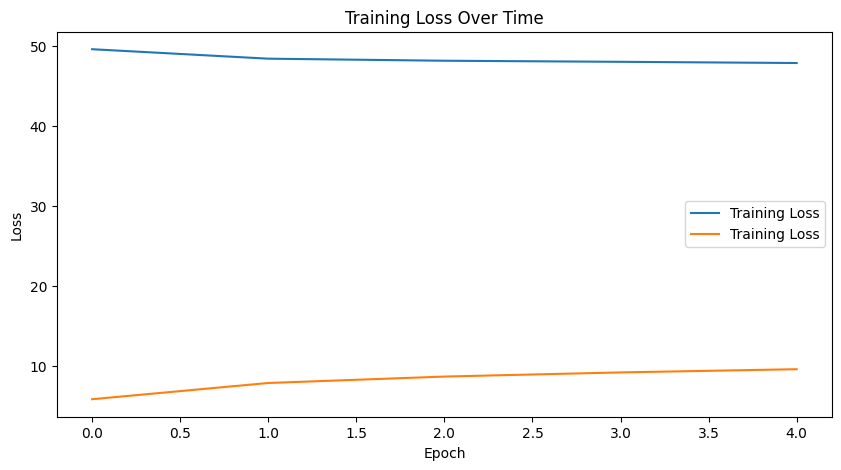

 25%|██▌       | 5/20 [06:53<20:41, 82.77s/it]


KeyboardInterrupt: 

In [12]:
if __name__ == "__main__":
    # show_images()
    torch.cuda.empty_cache()
    num_workers = 4
    pin_memory = True
    batch_size = 64
    n_samples, in_channels, s_img, latent_dims, padding = 1, 3, 256, 512,1
    hdim_e = [3, 64, 128, 256, 512, 512, 512, 512, 512] #choose hidden dimension encoder
    hdim_d_output = [512, 512, 512, 512, 512, 256, 128, 64, 3]
#     hdim_d_input = [512, 1024, 1024, 1024, 1024, 512, 256, 128, 3] #choose hidden dimension decoder
    hdim_d_input = hdim_d_output
    in_channels_dis = 6 # 6 for two images
    hdim_dis = [64, 128, 256, 256, 512, 512, 1] #choose hidden dimension discriminator
    output_shape = (n_samples, 1, 30, 30)
    
    kernel_size = (4,4)

   # Define the transformation pipeline with added jitter
    transform = transforms.Compose([
        transforms.Resize(256, interpolation=transforms.InterpolationMode.NEAREST),  # Resize to 256x256 using nearest neighbor method
        transforms.RandomCrop(256),  # Apply random cropping to introduce jitter
        transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
        # Random jitter through changes in brightness, contrast, saturation, and hue
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
        # Random affine transformations for scaling and rotation
        transforms.RandomAffine(degrees=10, scale=(0.95, 1.05)),
        transforms.ToTensor(),  # Convert images to tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
    ])

    # Initialize the dataset
    paired_dataset = PairedImageDataset(rootA=r'/kaggle/input/euvp-dataset/EUVP/Paired/underwater_dark/trainA',
                                        rootB=r'/kaggle/input/euvp-dataset/EUVP/Paired/underwater_dark/trainB',
                                        transform=transform)

    # Initialize DataLoader
    EUVP_data = DataLoader(
        paired_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory)

   # Fetch a single batch
    images_a, images_b = next(iter(EUVP_data))
#     _ , img_x = EUVP_data

    #Set the number of dimensions of the latent space
    # latent_dims = [2,3]
    s_img = np.size(images_a[1][0], axis = 1) #get image size (height = width) from a data sample

    #initialize generator model
    model_gen = Generator(latent_dims=latent_dims,
                        s_img=s_img,
                        hdim_e=hdim_e, 
                        hdim_d_input=hdim_d_input,
                        hdim_d_output=hdim_d_output, 
                        padding=padding,
                        kernel_size=kernel_size)
    #intit dis
    model_dis = Discriminator(latent_dims, s_img, hdim_dis)

    # Create a writer to write to Tensorboard
    writer = SummaryWriter()

    #Create instance of Autoencoder
    device = try_gpu()
    print(device)
    
    if torch.cuda.is_available():
        model_gen= nn.DataParallel(model_gen)
        model_gen.to(device)
        model_dis = nn.DataParallel(model_dis)
        model_dis.to(device)

    # Create loss function and optimizer
    criterion_l1 = F.l1_loss 
    criterion_bce = F.binary_cross_entropy
    
    optimizer_gen = optim.Adam(model_gen.parameters(), lr=2e-4, betas=(0.5, 0.999))
    optimizer_dis = optim.Adam(model_dis.parameters(), lr=2e-4, betas=(0.5, 0.999))

    # Set the number of epochs to for training
    epochs = 20
    
    plt.ion()  # Enable interactive mode
    
    losses_gen = []
    losses_dis = [] 
    
    for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
        # Train on data
        train_loss_gen, train_loss_dis = train_gan(EUVP_data, model_gen,model_dis, optimizer_gen, optimizer_dis, criterion_l1, criterion_bce, pin_memory, device)

        # Write metrics to Tensorboard
        writer.add_scalars("Loss", {'Train': train_loss_gen}, epoch)

        losses_gen.append(train_loss_gen.item())
        losses_dis.append(train_loss_dis.item())
        
#         Visualization code
        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.plot(losses_gen, label='Training Loss Generator')
        plt.plot(losses_dis, label='Training Loss Discriminator')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss Over Time')
        plt.legend()
        plt.show()
        

    plt.ioff()  # Disable interactive mode
    writer.close()

In [13]:

# make a folder
count = 0
image_counter = 10
path = '/kaggle/working/test'
path_loop = None
# Initialize DataLoader
EUVP_data = DataLoader(paired_dataset, batch_size=5, shuffle=False, num_workers=4)

print("start printing")
# Store somep images
for i, data in enumerate(EUVP_data):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    y_out = model_gen.forward(inputs)
#     y_out = torch.tanh(y_out)

    for x in range(len(inputs) - 1):
        path_loop = f"{path}/test{count}"
        if not (os.path.exists(path_loop) and os.path.isdir(path_loop)):
            os.makedirs(path_loop)

        name = (f'{path_loop}/image_in{count}.jpg')
        save_image(inputs[x], name)
        name = (f'{path_loop}/image_out{count}.jpg')
        save_image(y_out[x], name)
        name = (f'{path_loop}/image_truth{count}.jpg')
        save_image(labels[x], name)
        count += 1

        if (count == image_counter):
            break
    break


start printing


In [ ]:
%load_ext tensorboard
%tensorboard --logdir /kaggle/working/runs

In [ ]:
 %reload_ext tensorboard

In [ ]:
!kill 292